# Imports

In [1]:
import os
import h5py
import sympy
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Math
from scipy.interpolate import CubicSpline

from tree import SVTree
from nodes import FunctionNode
from regressor import SVRegressor

# Setup

In [2]:
basePath = os.path.join('results', 'smeam_dup')
fromArchive = False

basePath = os.path.join('results', 'mo_smooth2')
fromArchive = True

In [3]:
choice = 0

if fromArchive:
    allTreeNames = glob.glob(os.path.join(basePath, '*'))
    del allTreeNames[allTreeNames.index(os.path.join(basePath, 'archive.pkl'))]
    
    bestCost = np.inf
    bestIdx = 0
    
    worstCost = 0
    worstIdx = 0
    
    archive = pickle.load(open(os.path.join(basePath, 'archive.pkl'), 'rb'))
    
    allErrors = []
    allLatex = []

    for i, treePath in enumerate(allTreeNames):
        treeName = os.path.split(treePath)[-1]
        
        tree = pickle.load(open(os.path.join(treePath, 'tree.pkl'), 'rb'))

        entry = archive[treeName]
        tree.bestParams = entry.bestParams

        errors = entry.bestErrors
    
        latex = SVTree([
            FunctionNode(n.description) if isinstance(n, FunctionNode)
            else n
            for n in tree.nodes
        ]).latex()

        sumErrors = np.sum(errors)
        
        if sumErrors < bestCost:
            bestCost = sumErrors
            bestIdx = i
        
        if sumErrors > worstCost:
            worstCost = sumErrors
            worstIdx = i
        
        allErrors.append(sumErrors)
        allLatex.append(latex)
        
    allLatex = np.array(allLatex)[np.argsort(allErrors)]
    allTreeNames = np.array(allTreeNames)[np.argsort(allErrors)]
    allErrors = np.array(allErrors)[np.argsort(allErrors)]

    for latex, errors in zip(allLatex, allErrors):
        display(Math('{:.2f}<->{}'.format(
            errors,
            sympy.latex(sympy.sympify(latex, evaluate=False), mul_symbol='dot')
        )))
            
    treePath = allTreeNames[choice]
    treePath = allTreeNames[1]
    treeName = os.path.split(treePath)[-1]

    archive = pickle.load(open(os.path.join(basePath, 'archive.pkl'), 'rb'))
    tree = pickle.load(open(os.path.join(basePath, treeName, 'tree.pkl'), 'rb'))
    
    entry = archive[treeName]
    tree.bestParams = entry.bestParams
    
    errors = entry.bestErrors
else:
    files = sorted(glob.glob(os.path.join(basePath, 'tree*')))
    intIndices = [int(s[s.find('tree')+5:s.find('.pkl')]) for s in files]

    argsort = np.argsort(intIndices)

    treeFile = np.array(files)[argsort][-1]
    tree = pickle.load(open(treeFile, 'rb'))
    
    errorFiles = sorted(glob.glob(os.path.join(basePath, 'errors*')))
    errorFile  = np.array(errorFiles)[argsort][-1]
    errors = pickle.load(open(errorFile, 'rb'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:
treePath

'results/mo_smooth2/mul(ffg, ffg)'

# Plotting

In [29]:
def plotSpline(x, y, bc):
    cs = CubicSpline(x, y, bc_type=((1, bc[0]), (1, bc[1])))
#     cs = CubicSpline(x, y, bc_type='natural')
    
    plotX = np.linspace(x[0]-.1, x[-1]+.1, 100)
    plotY = cs(plotX)
    
    return plotX, plotY

In [30]:
splits = []
types = []

for svNode in tree.svNodes:
    for comp in svNode.components:
        splits.append(svNode.numParams[comp]+len(svNode.restrictions[comp]))
        types.append(comp)

In [31]:
splitParams = np.array_split(tree.fillFixedKnots(tree.bestParams)[0], np.cumsum(splits)[:-1])

<IPython.core.display.Math object>

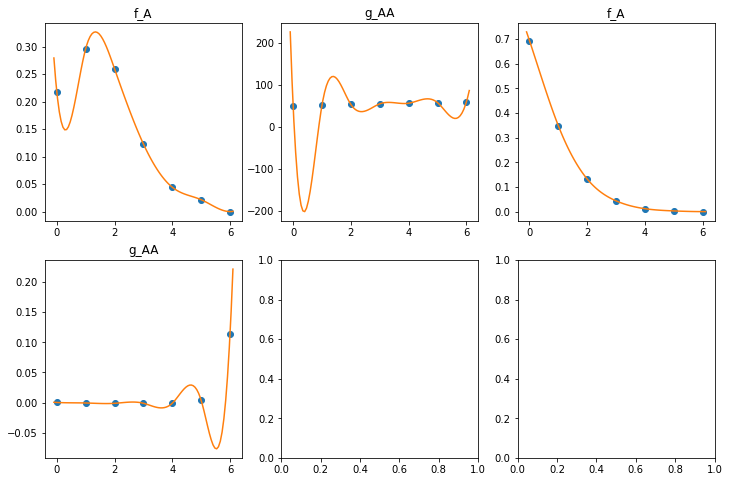

In [34]:
numRows = int(max(1, np.ceil(len(splitParams)/3)))

fig, axes = plt.subplots(numRows, 3, figsize=(12, 4*numRows))

compNames = np.hstack([svNode.components for svNode in tree.svNodes])

display(Math('{}'.format(
    sympy.latex(sympy.sympify(allLatex[choice], evaluate=False), mul_symbol='dot')
)))
    
for i, spline in enumerate(splitParams):
    y, bc = spline[:-2], spline[-2:]
    
    x = np.arange(len(y))
    
    plotX, plotY = plotSpline(x, y, bc)
    
    row = i//3
    col = i%3
    
    if numRows > 1:
        ax = axes[row][col]
    else:
        ax = axes[col]
    
    ax.plot(x, y, 'o')
    ax.plot(plotX, plotY)
    ax.set_title(compNames[i].decode('utf-8'))
    
# _ = plt.suptitle(r'${}$'.format(sympy.latex(sympy.sympify(allLatex[choice], evaluate=False), mul_symbol='dot')))

In [33]:
splitParams[2]

array([ 0.69400443,  0.34843976,  0.13220814,  0.04362019,  0.01183334,
        0.00279363,  0.        , -0.35311995,  0.        ])

# Errors

## Directly from logs

In [53]:
energyWeight = 1
forcesWeight = 1

unweighted = errors.copy()
unweighted[::2] /= energyWeight
unweighted[1::2] /= forcesWeight

np.sqrt(np.average(unweighted**2))

0.23699244422719676

In [54]:
with h5py.File('../svreg_data/mlearn/Mo/Mo.hdf5', 'r') as db:
        
    print(
        '{:>45} average errors || {:.6f} {:.6f}\n'.format(
            str(tree),
            np.sqrt(np.average(unweighted[::2]**2)),
            np.sqrt(np.average(unweighted[1::2]**2)),
        )
    )
    
    print(
        '{:>60} || {} {}'.format(
            'structName',
            '(eV/atom)',
            '(eV/A)'
        )
    )
    
    for i, structName in enumerate(sorted(db)):
        print(
            '{:>60} || {:.6f} {:.6f}'.format(
                structName,
                unweighted[2*i],
                unweighted[2*i+1]
            )
        )

            add(rho, add(ffg, mul(rho, ffg))) average errors || 0.011502 0.334961

                                                  structName || (eV/atom) (eV/A)
                                        Ground_state_crystal || 0.000000 0.014663
                         Mo_3x3x3_cell_mode_1_strain_-0.0200 || 0.001451 0.012469
                         Mo_3x3x3_cell_mode_1_strain_-0.0400 || 0.001806 0.015489
                         Mo_3x3x3_cell_mode_1_strain_-0.0600 || 0.001430 0.023469
                         Mo_3x3x3_cell_mode_1_strain_-0.0800 || 0.008387 0.028313
                         Mo_3x3x3_cell_mode_1_strain_-0.1000 || 0.020667 0.045762
                          Mo_3x3x3_cell_mode_1_strain_0.0200 || 0.000958 0.012809
                          Mo_3x3x3_cell_mode_1_strain_0.0800 || 0.003137 0.015803
                         Mo_3x3x3_cell_mode_2_strain_-0.0200 || 0.001466 0.013145
                         Mo_3x3x3_cell_mode_2_strain_-0.0400 || 0.001829 0.017188
                

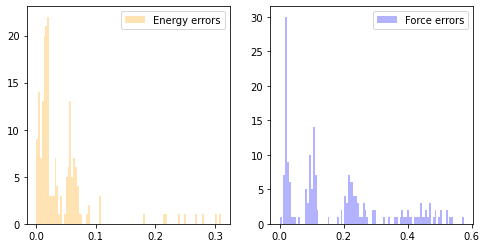

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].hist(errors[::2] , bins=100, alpha=0.3, label='Energy errors', color='orange')
ax[1].hist(errors[1::2], bins=100, alpha=0.3, label='Force errors', color='blue')

ax[0].legend()
ax[1].legend()

## External validation

In [27]:
tree.bestParams.shape

(32,)

In [28]:
popDict = tree.parseArr2Dict(np.atleast_2d(tree.bestParams), fillFixedKnots=True)

for svName in popDict:
    for bondType in popDict[svName]:
        popDict[svName][bondType] = [popDict[svName][bondType]]

In [29]:
def buildSVNodePool(group):
    """Prepare svNodePool for use in tree construction"""

    svNodePool = []

    # `group` is a pointer to an entry for a structure in the database
    for svName in sorted(group):
        svGroup = group[svName]

        restrictions = None
        if 'restrictions' in svGroup.attrs:
            restrictions = []
            resList = svGroup.attrs['restrictions'].tolist()
            for num in svGroup.attrs['numRestrictions']:
                tmp = []
                for _ in range(num):
                    tmp.append(tuple(resList.pop()))
                restrictions.append(tmp)

        svNodePool.append(
            SVNode(
                description=svName,
                components=svGroup.attrs['components'],
                numParams=svGroup.attrs['numParams'],
                bonds={
                    k:svGroup[k].attrs['components'] for k in svGroup.keys()
                },
                restrictions=restrictions,
                paramRanges=svGroup.attrs['paramRanges']\
                    if 'paramRanges' in group[svName].attrs else None
            )
        )

    return svNodePool

In [30]:
import h5py

with h5py.File('../svreg_data/mlearn/Mo/Mo.hdf5', 'r') as db:
    print(list(db['Ground_state_crystal']['ffg'].keys()))

['ffg_AAA']


In [34]:
import cma

from mpi4py import MPI

from nodes import SVNode
from settings import Settings
from database import SVDatabase
from evaluator import SVEvaluator
from regressor import SVRegressor

settingsPath = 'examples/settings.in'
databasePath = '../svreg_data/mlearn/Mo/Mo.hdf5'
# databasePath = '../s-meam/data/fitting_databases/mlearn/data/Mo/Mo.hdf5-strain'

settings = Settings.from_file(settingsPath)
settings['PROCS_PER_PHYS_NODE'] = 1
settings['PROCS_PER_MANAGER'] = 1

worldComm = MPI.COMM_WORLD
with SVDatabase(settings['databasePath'], 'r') as database:
    engVec = database['Ground_state_crystal']['ffg']['ffg_AAA']['energy'][()]
    fcsVec = database['Ground_state_crystal']['ffg']['ffg_AAA']['forces'][()]
    
    structNames = list(database.keys())
    structNames = ['Ground_state_crystal']

    if settings['refStruct'] not in structNames:
        raise RuntimeError(
            "The reference structure must be included in structNames."
        )

    evaluator =  SVEvaluator(worldComm, structNames, settings)
    evaluator.distributeDatabase(database)

    trueValues = database.loadTrueValues()

#     numStructs = len(trueValues)
    
    refStruct = settings['refStruct']
    treeErrors = np.zeros(2*len(database))
    
    svNodePool = buildSVNodePool(database[settings['refStruct']])
    
    regressor = SVRegressor(
        settings, svNodePool, cma.CMAEvolutionStrategy, [1.0, {'popsize': 1}]
    )
    
    regressor.trees = [tree]
    
    treePopulations = [tree.parseArr2Dict(np.atleast_2d(tree.bestParams), fillFixedKnots=True)]
    
    # Group all dictionaries into one
    populationDict = {}
    for svNode in svNodePool:
        populationDict[svNode.description] = {}
        for bondType in svNode.bonds:
            populationDict[svNode.description][bondType] = []

    for treeDict in treePopulations:
        for svName in treeDict.keys():
            for bondType, pop in treeDict[svName].items():
                populationDict[svName][bondType].append(pop)
                            
    svEng = evaluator.evaluate(populationDict, evalType='energy')
    svFcs = evaluator.evaluate(populationDict, evalType='forces')
    
    energies, forces = regressor.evaluateTrees(svEng, svFcs, 1)
    
    for structName in sorted(structNames):
        eng = energies[structName][0] - energies[refStruct][0]
        fcs =   forces[structName][0]
        
        engErrors = eng - trueValues[structName]['energy']
        fcsErrors = fcs - trueValues[structName]['forces']
        
        treeErrors[2*i]   = abs(engErrors)
        treeErrors[2*i+1] = np.average(np.abs(fcsErrors), axis=(1, 2))
        
        print(
            '{:>60} || {:.6f} {:.6f} ({:.6f})'.format(
                structName,
                treeErrors[2*i],
                treeErrors[2*i+1],
                energies[structName][0][0]
            )
        )
# del evaluator

Evaluator.eval() forces: [[[ 5.09266539e+00 -9.27719863e-01 -1.15435505e+00]
  [ 1.27736389e+01  8.90342198e+00  6.70326012e-01]
  [-1.51957321e+01  1.97656184e+01 -2.75610927e+00]
  [-3.48295849e+00  1.55587427e+01 -1.62164406e+01]
  [-2.04935615e+01  4.62515374e+00 -2.68536953e-01]
  [ 2.16099353e+01  5.73452699e+00  1.35743271e+01]
  [ 9.33906818e+00  5.86047701e+00  5.97351077e+00]
  [-2.89610032e+01 -1.23009598e+01 -2.39156712e+00]
  [ 1.82949410e+01 -2.40169265e+01  1.20639810e+01]
  [-2.88367219e+01  2.24843269e+01 -1.33822250e+01]
  [ 7.23731732e+00 -3.06379972e+01  2.17988797e+01]
  [ 1.06389936e+01  1.11043220e+01  7.52858729e+00]
  [-8.29692471e+00 -3.03815504e+01 -7.21885992e+00]
  [ 1.24391309e+01  1.46642474e+01 -7.42163955e+00]
  [-1.48796896e+01 -2.95499094e+01  5.25627026e+00]
  [-3.88640829e+00 -3.72782469e+00  1.48952415e+01]
  [ 1.74701422e+01  4.48616929e+00 -3.03831621e+01]
  [-1.94144372e+01  1.84154110e+01  1.34889650e+01]
  [-3.92924892e+00 -2.40164962e+01 -2.0

In [10]:
from scipy.special import erf

/home/jvita/Programs/miniconda2/envs/parhdf5/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


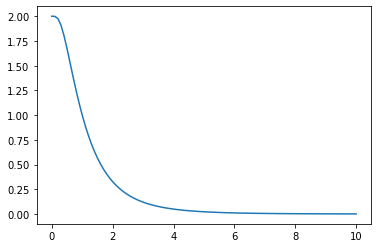

In [18]:
fig, ax = plt.subplots()

x = np.linspace(0, 10, 100)
ax.plot(x, 1-erf(np.log(x)))

In [19]:
1-erf(np.log(x))

/home/jvita/Programs/miniconda2/envs/parhdf5/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([2.00000000e+00, 1.99881362e+00, 1.97629491e+00, 1.90867730e+00,
       1.80002313e+00, 1.66597825e+00, 1.52118092e+00, 1.37600848e+00,
       1.23685949e+00, 1.10722126e+00, 9.88659792e-01, 8.81551842e-01,
       7.85579776e-01, 7.00050408e-01, 6.24093620e-01, 5.56782297e-01,
       4.97201968e-01, 4.44488927e-01, 3.97848925e-01, 3.56564155e-01,
       3.19993391e-01, 2.87568330e-01, 2.58787995e-01, 2.33212354e-01,
       2.10455803e-01, 1.90180917e-01, 1.72092635e-01, 1.55932998e-01,
       1.41476443e-01, 1.28525632e-01, 1.16907805e-01, 1.06471578e-01,
       9.70841656e-02, 8.86289679e-02, 8.10034728e-02, 7.41174426e-02,
       6.78913431e-02, 6.22549816e-02, 5.71463281e-02, 5.25104931e-02,
       4.82988410e-02, 4.44682204e-02, 4.09802950e-02, 3.78009622e-02,
       3.48998459e-02, 3.22498552e-02, 2.98267981e-02, 2.76090449e-02,
       2.55772333e-02, 2.37140095e-02, 2.20038018e-02, 2.04326211e-02,
       1.89878862e-02, 1.76582690e-02, 1.64335587e-02, 1.53045418e-02,
      

# Direct evaluation tests

In [5]:
str(tree)

'mul(ffg, ffg)'

In [6]:
import os
from ase.io import read

In [7]:
atoms = read('/home/jvita/scripts/s-meam/data/fitting_databases/mlearn/data/Mo/lammps/Ground_state_crystal.data', format='lammps-data', style='atomic')

In [8]:
y = tree.fillFixedKnots(tree.bestParams)[0]
y.shape

(36,)

### Compare energies to old

In [25]:
newEng = tree.directEvaluation(y, atoms, evalType='energy')# / len(atoms)

In [35]:
energies[refStruct][0], newEng

(array([-3766.25900969]), array([-3766.25862273]))

In [36]:
diff = abs(energies[refStruct][0] - newEng) / len(atoms)

np.max(diff), np.average(diff), np.std(diff)

(7.165842682163067e-06, 7.165842682163067e-06, 0.0)

### Compare forces to old

In [37]:
newFcs = tree.directEvaluation(y, atoms, evalType='forces')

In [38]:
diff = abs(fcs - newFcs)

np.max(diff), np.average(diff), np.std(diff)

(0.0001669259939278689, 3.908781078218391e-05, 2.8679154892053747e-05)

### Compare SVs to old

In [9]:
from summation import _implemented_sums
node = tree.svNodes[0]
sums = _implemented_sums[node.description](
    name=node.description,
    components=node.components,
    numParams=node.numParams,
    restrictions=node.restrictions,
    paramRanges=node.paramRanges,
    bonds=node.bonds,
    cutoffs=(2.4, 5.2),
    numElements=1,
)

engSV, fcsSV, trackerNew = sums.loop(atoms, evalType='vector', bondType='ffg_AAA')

In [48]:
sums.components[0]

b'f_A'

In [49]:
np.linspace(sums.cutoffs[0], sums.cutoffs[1], sums.numParams[b'f_A'] + len(sums.restrictions[b'f_A']) - 2)

array([2.4       , 2.86666667, 3.33333333, 3.8       , 4.26666667,
       4.73333333, 5.2       ])

In [60]:
splitParams[0]

array([ 0.217952  ,  0.29626718,  0.25977489,  0.12300407,  0.04432763,
        0.02163163,  0.        , -0.50476742,  0.        ])

In [61]:
newSpline.M @ splitParams[0]

array([-0.50476742,  0.26360209, -0.28077953, -0.25431825, -0.08696557,
       -0.04949944,  0.        ])

In [54]:
newSpline = sums.fSplines[0]
newSpline.buildDirectEvaluator(splitParams[0])

In [58]:
newSpline.bc_type

('fixed', 'fixed')

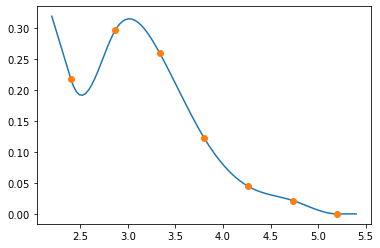

In [67]:
fig, ax = plt.subplots()

x = np.linspace(2.2, 5.4, 100)
y = [newSpline(x_i) for x_i in x]

ax.plot(x, y)
ax.plot(newSpline.knots, splitParams[0][:-2], 'o')

### Recreate old

In [12]:
atoms.get_chemical_symbols()
atoms.set_chemical_symbols(['Mo']*len(atoms))

In [13]:
import sys
sys.path.append('../s-meam/project/')
from src.database import Database

ic = 2.4
oc = 5.2
points_per_spline = 7

x_pvec = np.concatenate([
    np.tile(np.linspace(ic, oc, points_per_spline), 2),
    np.tile(np.linspace(-1, 1, points_per_spline), 1),
    np.tile(np.linspace(ic, oc, points_per_spline), 1),
    np.tile(np.linspace(-1, 1, points_per_spline), 1)]
)

x_indices = list(
    range(0, points_per_spline * 5, points_per_spline)
)

db = Database(
    os.path.join('Mo.hdf5-delete'), 'a',
    45, ['Mo'], x_pvec, x_indices, [ic, oc],
    overwrite=False,
)

# db.prepare_file_structure(['Ground_state_crystal'], ntypes=1)
trackerOld = db.add_structure('Ground_state_crystal', atoms, add_strained=False)

In [15]:
diff = np.abs(np.array(trackerNew) - np.array(trackerOld))

np.max(diff), np.average(diff), np.std(diff)

(8.881784197001252e-16, 1.2748991764374718e-18, 1.1864774490032234e-17)

In [16]:
oldEngVec = db['Ground_state_crystal']['ffg']['energy']['0']['0'][()]

In [40]:
diff = abs(oldEngVec - engSV)

np.max(diff), np.average(diff), np.std(diff)

(7.105427357601002e-15, 1.3915876009748063e-16, 3.7090989523638406e-16)

In [21]:
oldFcsVec = db['Ground_state_crystal']['ffg']['forces']['0']['0'][()]
oldFcsVec.shape

(8748, 729)

In [23]:
fcsSV.shape

(8748, 729)

In [24]:
diff = abs(oldFcsVec - fcsSV)

np.max(diff), np.average(diff), np.std(diff)

(1.7763568394002505e-14, 3.1884650820733444e-17, 1.9493268581223417e-16)

In [40]:
engVec[0][0]

0.42281004786491394

In [42]:
for i in range(engVec[0].shape[0]):
    print(i+1, abs(engVec[0][i] - engSV[0][i]))

1 3.6106950207503985e-09
2 3.5181497715086607e-09
3 1.6174124040091442e-08
4 8.120017991330997e-10
5 2.4870935755316737e-08
6 5.809237535459033e-09
7 1.1528420024164987e-09
8 2.0385138368994582e-10
9 1.7975383855006744e-10
10 0.0005992102840032265
11 0.0023967867805235743
12 0.008388779201836005
13 0.031058133884706074
14 0.12483049300209048
15 0.3869945794013281
16 0.05790204571443383
17 6.65783925446247e-05
18 0.006383948853142949
19 0.0006028137232962916
20 0.0024112645828950896
21 0.008439496583763875
22 0.026097603905342215
23 0.12596244365029086
24 0.41645411796363696
25 0.04942299738435449
26 6.698028688983601e-05
27 0.005603512122078366
28 7.248380287188088e-05
29 0.00028992755486167976
30 0.0010147718117350917
31 0.008778851165791052
32 0.015973599730294656
33 0.11758455305878027
34 0.015186529073657017
35 8.053613259677468e-06
36 0.001283479406649535
37 0.00014316512084977528
38 0.0005726701270989398
39 0.002004352372802696
40 0.06852093406245896
41 0.025515041122673124
42 0.

In [28]:
diff = abs(fcsVec - fcsSV)

np.max(diff), np.average(diff), np.std(diff)

(22.525550605037665, 0.010124693475750294, 0.12573248052952557)

In [29]:
diff

array([[9.69336778e-10, 1.20454521e-09, 3.06902470e-09, ...,
        3.42999270e-12, 2.76013543e-13, 6.90396193e-14],
       [7.09515910e-12, 3.49149355e-12, 3.20728409e-11, ...,
        8.22980653e-16, 6.02201584e-16, 9.89893068e-16],
       [1.39997260e-11, 2.19020633e-11, 8.70561579e-11, ...,
        3.82652957e-17, 1.14609374e-15, 6.56348420e-16],
       ...,
       [3.29219210e-09, 1.00746219e-08, 4.40511991e-09, ...,
        3.68893071e-15, 5.94097041e-16, 6.35422531e-16],
       [2.60829408e-09, 2.09012091e-08, 5.87499854e-09, ...,
        1.90224084e-14, 2.50681349e-15, 3.55117774e-15],
       [2.44309626e-10, 1.36869767e-10, 7.70383084e-10, ...,
        3.15279213e-12, 6.14398218e-13, 1.11409979e-13]])

In [22]:
splits = []
types = []

for svNode in tree.svNodes:
    for comp in svNode.components:
        splits.append(svNode.numParams[comp]+len(svNode.restrictions[comp]))
        types.append(comp)
        
splitParams = np.array_split(y, np.cumsum(splits)[:-1])

In [23]:
ycart1 = np.outer(np.outer(splitParams[0], splitParams[0]), splitParams[1]).ravel()
ycart2 = np.outer(np.outer(splitParams[2], splitParams[2]), splitParams[3]).ravel()

ycart1.shape

(729,)

In [24]:
eng1 = (engSV @ ycart1).sum()
eng2 = (engSV @ ycart2).sum()
eng1*eng2 - newEng

array([-2.5920599e-11])

In [25]:
fcs1 = (fcsSV @ ycart1).reshape(3, len(atoms), len(atoms)).sum(axis=-1).swapaxes(0, 1)
fcs2 = (fcsSV @ ycart2).reshape(3, len(atoms), len(atoms)).sum(axis=-1).swapaxes(0, 1)

diff = (fcs1*eng2 + eng1*fcs2) - newFcs

np.max(diff), np.average(diff), np.std(diff)

(3.0464519795714295e-12, 4.2880993680437257e-14, 1.1348888445235968e-12)

# Lattice constant tests

In [10]:
import ase.build
from ase.io import Trajectory, read, write

y = tree.fillFixedKnots(tree.bestParams)[0]

elements = ['Cu', 'Ge', 'Li' , 'Mo', 'Ni', 'Si']
crystals = ['fcc', 'diamond', 'bcc', 'bcc', 'fcc', 'diamond']

elem = 'Mo'

types = [elem]
cryst = crystals[elements.index(elem)]

atoms = ase.build.bulk(elem, cryst, cubic=True, a=3.4188376753507015)
traj = Trajectory("test.traj", 'w')

low = 2.5; high = 10

a_linspace = np.linspace(low, high, 100)
for a in a_linspace:
    scaled_atoms = atoms.copy()

    cell = scaled_atoms.get_cell()
    cell[0,0] = cell[1,1] = cell[2, 2,] = a

    scaled_atoms.set_cell(cell, scale_atoms=True)

    traj.write(scaled_atoms)

configs = ase.io.read("test.traj@:")

energies = [tree.directEvaluation(y, config, evalType='energy') / len(config) for config in configs]
a_trace = [config.cell[0,0] for config in configs]

os.remove('test.traj')

/home/jvita/Programs/miniconda2/envs/parhdf5/lib/python3.6/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


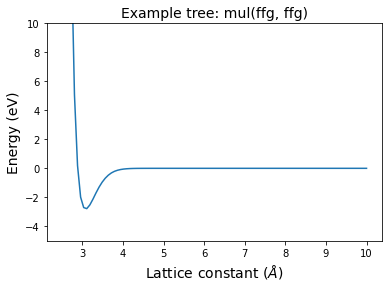

In [11]:
fig, ax = plt.subplots()

ax.plot(a_trace, energies)

ax.set_ylim([-5, 10])
ax.set_xlabel(r"Lattice constant ($\AA$)", fontsize=14)
ax.set_ylabel("Energy (eV)", fontsize=14)
ax.set_title("Example tree: {}".format(tree), fontsize=14)
print()

In [21]:
min_idx = np.argmin(energies)

min_a = a_trace[min_idx]

expected_a = [3.621, 5.763, 3.427, 3.168, 3.508, 5.469]

err = (min_a - expected_a[elements.index(elem)])/expected_a[elements.index(elem)]

print(expected_a[elements.index(elem)], min_a, err)

3.168 3.106060606060606 -0.019551576369758263
